<a href="https://colab.research.google.com/github/indhujaya2014-web/Project3_EcoType_Forest-Cover-Classification/blob/main/Project_3_EcoType_Forest_Cover_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ----------------
# Imports
# ----------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RaerrdedtndomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import joblib

# ----------------
# Load Dataset
# ----------------
df = pd.read_csv("cover_type.csv")

# ----------------
# Data Understanding
# ----------------
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nInfo:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())
display(df.describe())
print(df['Cover_Type'].value_counts())
print("\nFirst 5 rows:")
display(df.head())

# ----------------
# Handle Missing Values (Removed - No missing values detected)
# ----------------
numeric_cols = df.select_dtypes(include=['number']).columns

imputer = SimpleImputer(strategy='median')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

print("Imputation complete! No more missing values.")

# ----------------
# Fix Skewness
# ----------------
skewed_cols = [
    'Horizontal_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Horizontal_Distance_To_Fire_Points'
]

for col in skewed_cols:
    df[col] = np.log1p(df[col])

# Vertical distance may have negatives
min_vert = df['Vertical_Distance_To_Hydrology'].min()
df['Vertical_Distance_To_Hydrology'] = np.log1p(df['Vertical_Distance_To_Hydrology'] - min_vert)

# ----------------
# Encode Target
# ----------------
le = LabelEncoder()
df['Cover_Type_Encoded'] = le.fit_transform(df['Cover_Type'])

X = df.drop(columns=['Cover_Type', 'Cover_Type_Encoded'])
y = df['Cover_Type_Encoded']

# ----------------
# Train Test Split
# ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ----------------
# Handle Class Imbalance using SMOTE
# ----------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ----------------
# Feature Scaling
# ----------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# ----------------
# Model Training
# ----------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=300),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss')
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train_res)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

# ----------------
# Hyperparameter Tuning for Best Model
# ----------------
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)

#-----------------
#  Randomized SearchCV
#-----------------
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_grid, n_iter=5, cv=3, scoring='accuracy', verbose=1, random_state=42, n_jobs=1
)

random_search.fit(X_train_scaled, y_train_res)

best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# ----------------
# Final Evaluation
# ----------------
y_pred_best = best_model.predict(X_test_scaled)
print("\nFinal Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

# ----------------
# Save Model and Preprocessors
# ----------------
joblib.dump(best_model, "ecotype_model.pkl")
joblib.dump(scaler, "ecotype_scaler.pkl")
joblib.dump(le, "ecotype_label_encoder.pkl")

print("\nModel and preprocessors saved successfully!")

Shape: (145890, 13)

Columns: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Cover_Type', 'Wilderness_Area', 'Soil_Type']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145890 entries, 0 to 145889
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Elevation                           145890 non-null  int64 
 1   Aspect                              145890 non-null  int64 
 2   Slope                               145890 non-null  int64 
 3   Horizontal_Distance_To_Hydrology    145890 non-null  int64 
 4   Vertical_Distance_To_Hydrology      145890 non-null  int64 
 5   Horizontal_Distance_To_Roadways     145890 non-null  int64 
 6   Hillshade_9am                       145890 non-null  

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type
count,145890.000000,145890.000000,145890.000000,145890.000000,145890.000000,145890.000000,145890.000000,145890.000000,145890.000000,145890.000000,145890.000000,145890.000000
mean,2874.458949,141.127418,11.925574,251.824738,34.554322,3313.827541,217.368106,224.874748,139.788203,3044.958105,1.186593,23.364905
std,210.801279,107.719296,6.319326,192.473899,41.215776,1687.779953,21.590298,16.084851,31.311690,1761.882341,0.656571,8.215184
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,1.000000,1.000000
25%,2747.000000,54.000000,7.000000,95.000000,7.000000,1848.000000,207.000000,216.000000,121.000000,1608.000000,1.000000,12.000000
50%,2909.000000,108.000000,11.000000,212.000000,23.000000,3420.000000,222.000000,226.000000,140.000000,2713.000000,1.000000,29.000000
75%,3004.000000,217.000000,15.000000,362.000000,51.000000,4673.000000,232.000000,236.000000,159.000000,4478.000000,1.000000,29.000000
max,3849.000000,360.000000,61.000000,1343.000000,554.000000,7117.000000,254.000000,254.000000,248.000000,7173.000000,4.000000,40.000000


Cover_Type
Lodgepole Pine       103071
Spruce/Fir            31110
Aspen                  3069
Krummholz              2160
Ponderosa Pine         2160
Douglas-fir            2160
Cottonwood/Willow      2160
Name: count, dtype: int64

First 5 rows:


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Wilderness_Area,Soil_Type
0,2596,51,3,258,0,510,221,232,148,6279,Aspen,1,29
1,2590,56,2,212,-6,390,220,235,151,6225,Aspen,1,29
2,2804,139,9,268,65,3180,234,238,135,6121,Lodgepole Pine,1,12
3,2785,155,18,242,118,3090,238,238,122,6211,Lodgepole Pine,1,30
4,2595,45,2,153,-1,391,220,234,150,6172,Aspen,1,29


Imputation complete! No more missing values.

Logistic Regression Accuracy: 0.6785
              precision    recall  f1-score   support

           0       0.14      0.70      0.23       614
           1       0.84      0.88      0.86       432
           2       0.62      0.65      0.63       432
           3       0.64      0.97      0.77       432
           4       0.88      0.68      0.77     20614
           5       0.61      0.61      0.61       432
           6       0.49      0.66      0.56      6222

    accuracy                           0.68     29178
   macro avg       0.60      0.73      0.63     29178
weighted avg       0.77      0.68      0.71     29178


Decision Tree Accuracy: 0.9260
              precision    recall  f1-score   support

           0       0.74      0.86      0.80       614
           1       0.92      0.92      0.92       432
           2       0.75      0.79      0.77       432
           3       0.87      0.95      0.91       432
           4     

## Exploratory Data Analysis (EDA)

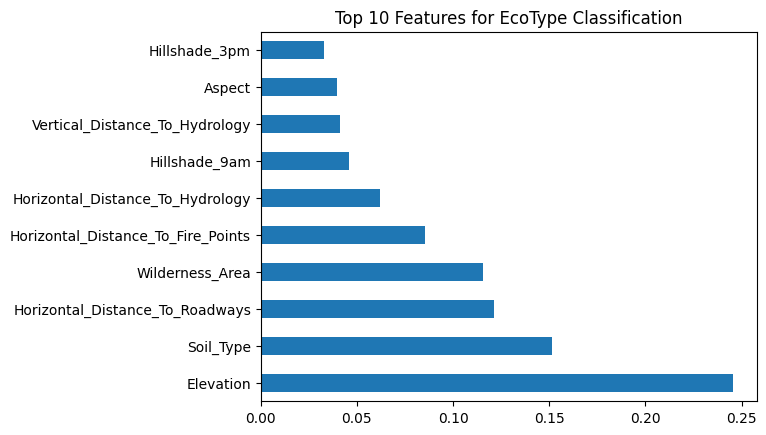

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# ----------------
# Quick visualization
# ----------------
feature_names = X.columns
importances = pd.Series(best_model.feature_importances_, index=feature_names)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Features for EcoType Classification")
plt.show()

/tmp/ipython-input-3742162363.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cover_Type', data=df, palette='viridis')


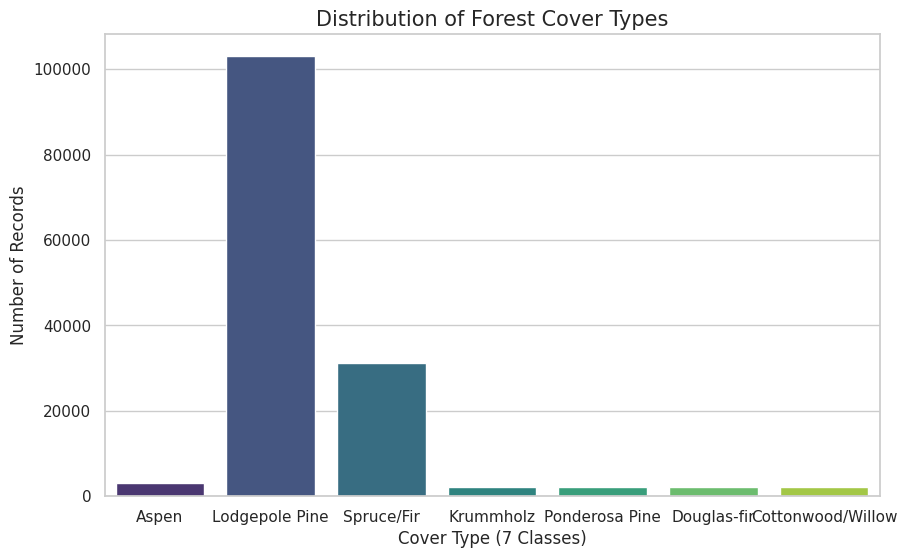

In [3]:
# ----------------
# visualization to identify class imbalance
# ----------------
import seaborn as sns
import matplotlib.pyplot as plt

# Set the visual style
sns.set_theme(style="whitegrid")

# ----------------
# Create the countplot
# ----------------
plt.figure(figsize=(10, 6))
sns.countplot(x='Cover_Type', data=df, palette='viridis')

# ----------------
# Add labels and title
# ----------------
plt.title('Distribution of Forest Cover Types', fontsize=15)
plt.xlabel('Cover Type (7 Classes)', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)

# Show the plot
plt.show()

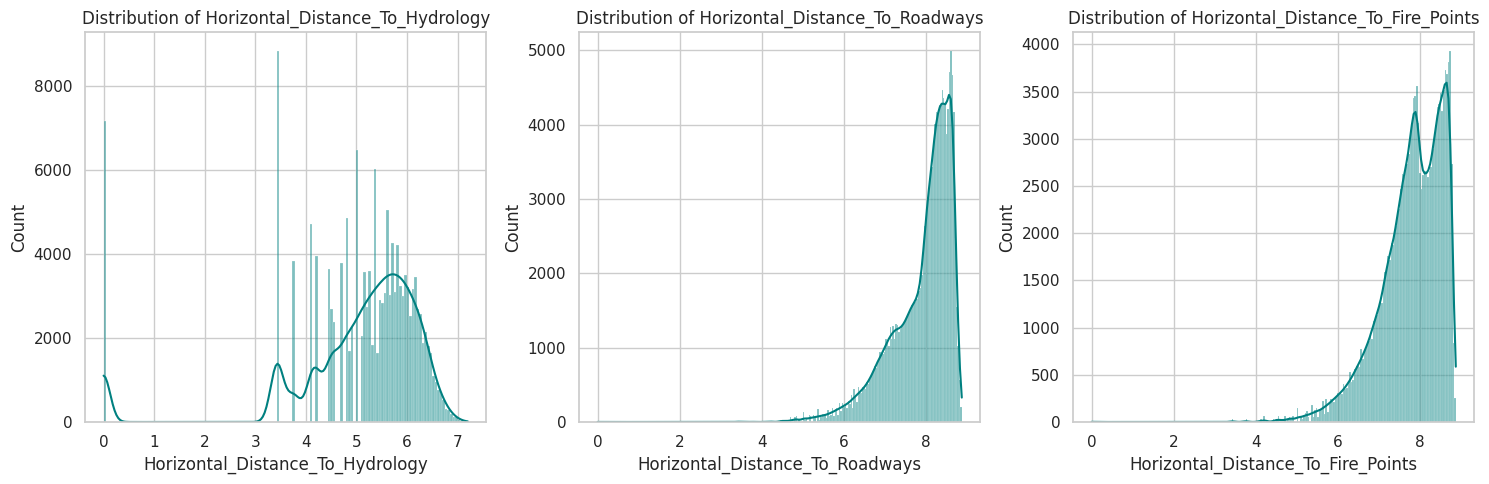

In [4]:
# ----------------
# List of continuous distance features
# ----------------
dist_cols = ['Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']

plt.figure(figsize=(15, 5))
for i, col in enumerate(dist_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, color='teal')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

/tmp/ipython-input-3570447245.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cover_Type', y='Elevation', data=df, palette='terrain')


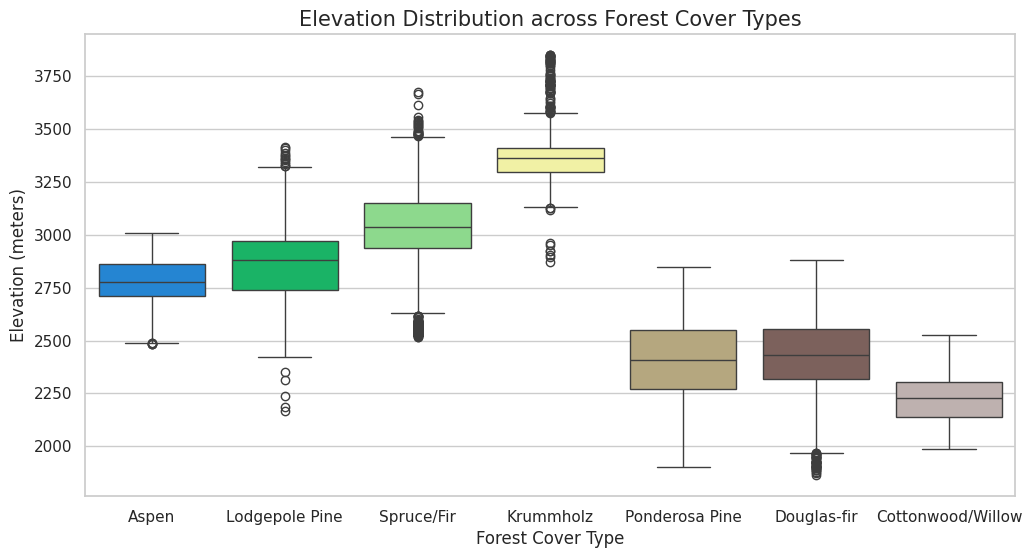

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the visual style
sns.set_theme(style="whitegrid")

# ----------------
#Elevation vs Cover_Type
# Create the boxplot
# ----------------
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cover_Type', y='Elevation', data=df, palette='terrain')

# Adding descriptive labels
plt.title('Elevation Distribution across Forest Cover Types', fontsize=15)
plt.xlabel('Forest Cover Type', fontsize=12)
plt.ylabel('Elevation (meters)', fontsize=12)

plt.show()

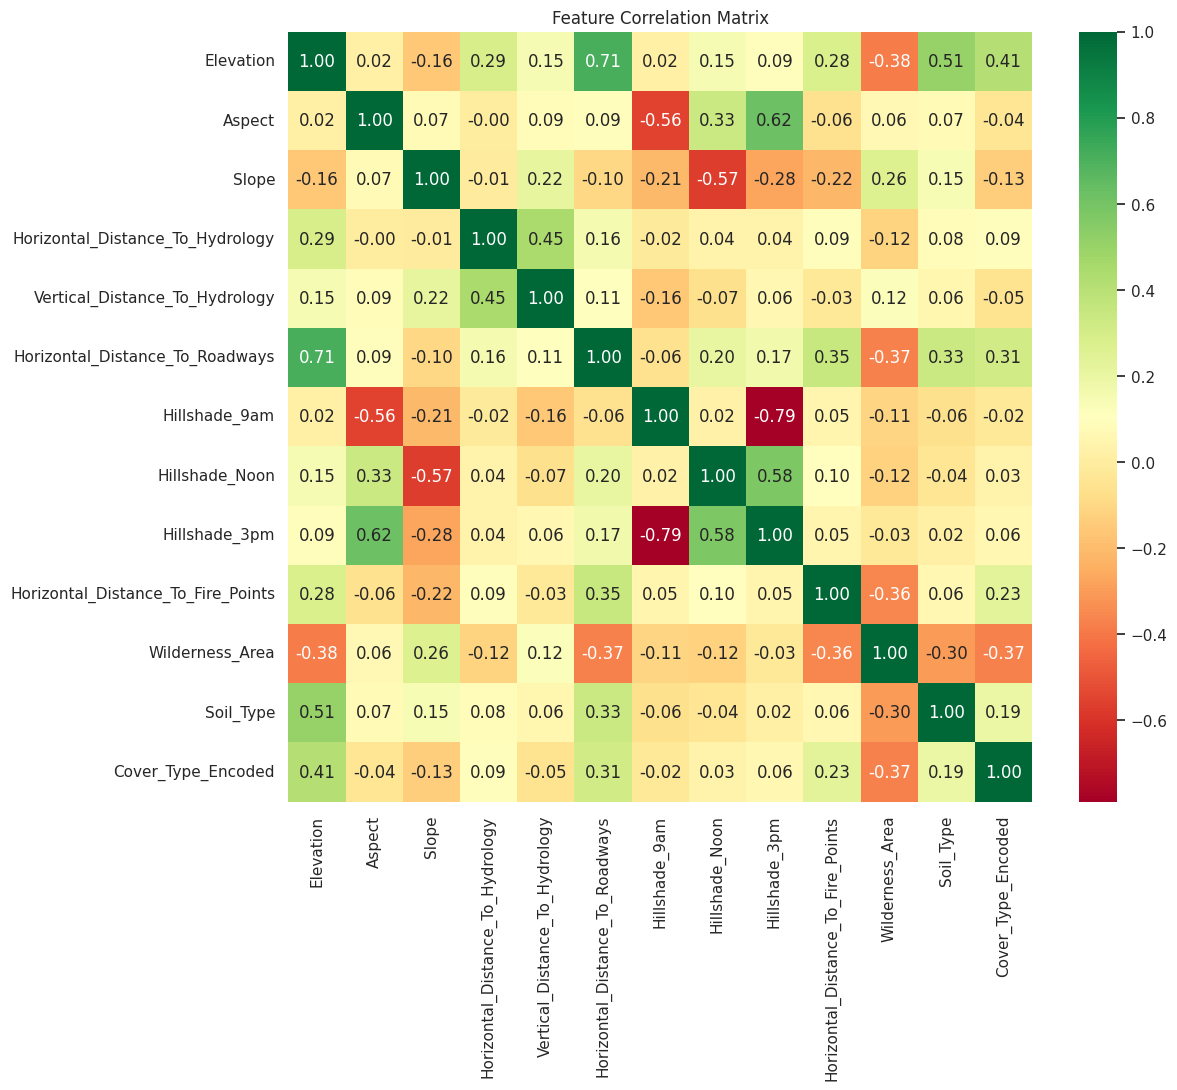

In [6]:
# ----------------
# Correlation Heatmap
# Calculate correlation only for numeric features
# ----------------
corr_matrix = df.corr(numeric_only=True)

#Pass the CALCULATED matrix (corr_matrix) into the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

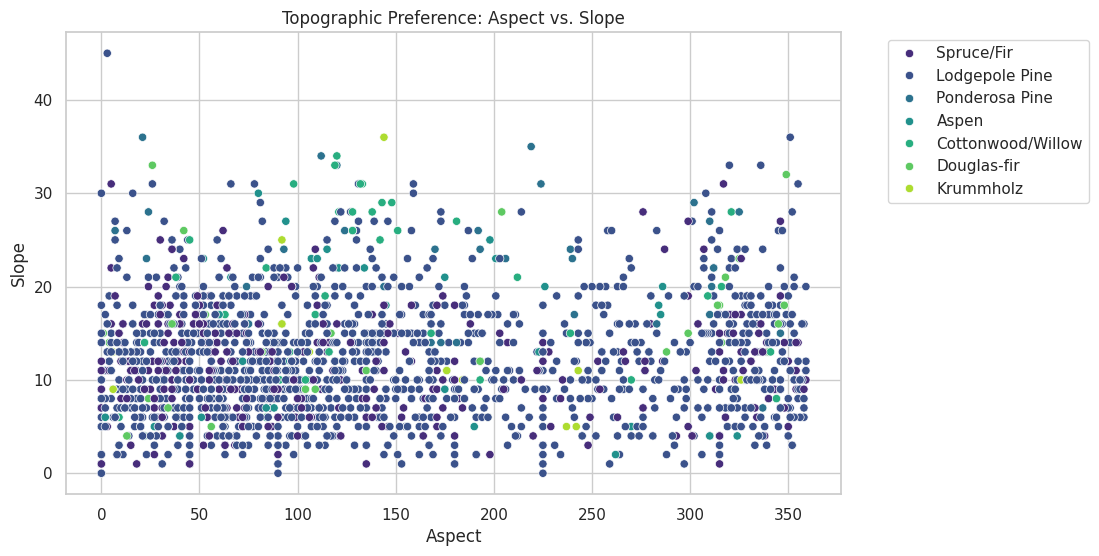

In [7]:
# ----------------
# Slope vs Aspect (Sampled for clarity)
# ----------------
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Aspect', y='Slope', hue='Cover_Type', data=df.sample(2000), palette='viridis')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Topographic Preference: Aspect vs. Slope')
plt.show()

## Build a Streamlit UI

In [9]:
!pip install -q streamlit
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
import subprocess
subprocess.Popen(["./cloudflared-linux-amd64", "tunnel", "--url", "http://localhost:8501"])
!nohup /content/cloudflared-linux-amd64 tunnel --url http://localhost:8501 &

--2026-01-19 13:11:17--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64 [following]
--2026-01-19 13:11:17--  https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/955e9d1b-ac5e-4188-8867-e5f53958a8fe?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-01-19T13%3A58%3A09Z&rscd=attachment%3B+filename%3Dcloudflared-linux-amd64&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2026-01-19

In [14]:
%%writefile ecotype.py
import streamlit as st
import numpy as np
import pandas as pd
import joblib

# -----------------------------
# Load saved model & preprocessors
# -----------------------------
model = joblib.load("ecotype_model.pkl")
scaler = joblib.load("ecotype_scaler.pkl")
label_encoder = joblib.load("ecotype_label_encoder.pkl")

# -----------------------------
# Page Config
# -----------------------------
st.set_page_config(page_title="EcoType - Forest Cover Predictor", layout="wide")

st.title("🌲 EcoType: Forest Cover Type Prediction")
st.write("Enter environmental and geographical feature values to predict forest cover type.")

# -----------------------------
# Input Fields
# -----------------------------
col1, col2, col3 = st.columns(3)

with col1:
    Elevation = st.number_input("Elevation (meters)", min_value=0, max_value=5000, value=2500)
    Aspect = st.number_input("Aspect (degrees)", min_value=0, max_value=360, value=180)
    Slope = st.number_input("Slope (degrees)", min_value=0, max_value=90, value=15)
    HD_Hydrology = st.number_input("Horizontal Distance to Hydrology", min_value=0, max_value=50000, value=1000)

with col2:
    VD_Hydrology = st.number_input("Vertical Distance to Hydrology", min_value=-500, max_value=500, value=50)
    HD_Roadways = st.number_input("Horizontal Distance to Roadways", min_value=0, max_value=50000, value=2000)
    Hillshade_9am = st.number_input("Hillshade 9am", min_value=0, max_value=255, value=200)
    Hillshade_Noon = st.number_input("Hillshade Noon", min_value=0, max_value=255, value=220)

with col3:
    Hillshade_3pm = st.number_input("Hillshade 3pm", min_value=0, max_value=255, value=180)
    HD_Fire = st.number_input("Horizontal Distance to Fire Points", min_value=0, max_value=50000, value=3000)
    Wilderness = st.selectbox("Wilderness Area", [1, 2, 3,4])
    Soil = st.selectbox("Soil Type", list(range(41)))

# -----------------------------
# Feature Order (must match training)
# -----------------------------
feature_names = [
    'Elevation',
    'Aspect',
    'Slope',
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Hillshade_9am',
    'Hillshade_Noon',
    'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points',
    'Wilderness_Area',
    'Soil_Type'
]

# -----------------------------
# Prepare Input DataFrame
# -----------------------------
input_dict = {
    'Elevation': Elevation,
    'Aspect': Aspect,
    'Slope': Slope,
    'Horizontal_Distance_To_Hydrology': HD_Hydrology,
    'Vertical_Distance_To_Hydrology': VD_Hydrology,
    'Horizontal_Distance_To_Roadways': HD_Roadways,
    'Hillshade_9am': Hillshade_9am,
    'Hillshade_Noon': Hillshade_Noon,
    'Hillshade_3pm': Hillshade_3pm,
    'Horizontal_Distance_To_Fire_Points': HD_Fire,
    'Wilderness_Area': Wilderness,
    'Soil_Type': Soil
}

input_df = pd.DataFrame([input_dict], columns=feature_names)

# -----------------------------
# Apply Same Transformations
# (log fixes used in training)
# -----------------------------
skewed_cols = [
    'Horizontal_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Horizontal_Distance_To_Fire_Points'
]

for col in skewed_cols:
    input_df[col] = np.log1p(input_df[col])

# Vertical distance log transform with shift
min_vert = -200
input_df['Vertical_Distance_To_Hydrology'] = np.log1p(input_df['Vertical_Distance_To_Hydrology'] - min_vert)

# -----------------------------
# Scale Input
# -----------------------------
input_scaled = scaler.transform(input_df)

# -----------------------------
# Prediction
# -----------------------------
if st.button("Predict Forest Cover Type"):
    prediction = model.predict(input_scaled)
    predicted_class = label_encoder.inverse_transform(prediction)[0]

    st.success(f"🌳 Predicted Forest Cover Type: **{predicted_class}**")

Overwriting ecotype.py


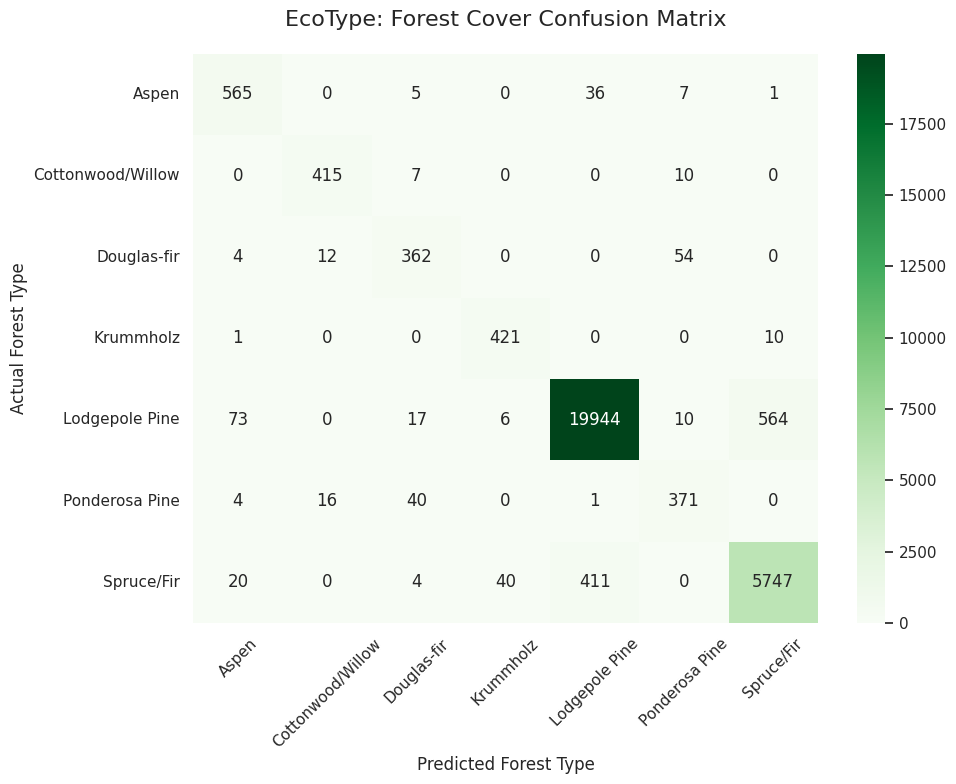

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_eco_confusion_matrix(y_true, y_pred, labels):
    """
    Generates a professional heatmap for the EcoType model evaluation.
    """
    # ----------------
    # Create the confusion matrix
    # ----------------
    cm = confusion_matrix(y_true, y_pred)

    # Set up the figure
    plt.figure(figsize=(10, 8))
    sns.set_theme(style="white")

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels, yticklabels=labels)

    plt.title('EcoType: Forest Cover Confusion Matrix', fontsize=16, pad=20)
    plt.ylabel('Actual Forest Type', fontsize=12)
    plt.xlabel('Predicted Forest Type', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the visualization for the report
    plt.savefig('ecotype_confusion_matrix.png', dpi=300)
    plt.show()

# Example Usage (Run this after your final model prediction):
forest_classes = le.classes_
plot_eco_confusion_matrix(y_test, y_pred_best, forest_classes)


In [15]:
!streamlit run /content/ecotype.py &>/content/logs.txt &  # here instead of app.py please rename with your file name

In [16]:
!grep -o 'https://.*\.trycloudflare.com' nohup.out | head -n 1 | xargs -I {} echo "Your tunnel url {}"

Your tunnel url https://tumor-national-kurt-leaf.trycloudflare.com
